# Environment

In [1]:
import re
import torch
import random
import torchaudio
import sam_classifier
from pathlib import Path
import pytorch_lightning as pl
from IPython.display import Audio
from helpers import plot as cora_plot
from helpers.path_utils import get_base_dir
from helpers.audio_utils import save_wave_to_wav

# Parameters

In [2]:
# Sample rate
SAMPLE_RATE = 4000

# Seconds to split each recording
# it will be the size of input (secs)
CHUNK_SECS = 3

# The upper bound the recording (input, output or both)
# is going to be filtered with Butterworth Filter (Hz)
CUTOFF_FREQ = 270
# How strict the Lowpass Filter is filtering undesired frequencies
FILTER_ORDER = 4

# Number of Mel frequency bands in the spectrogram
N_MELS = 128
# Window size for Fast Fourier Transform (FFT)
N_FFT = 1024
# Number of samples between successive windows (definition of overlap)
HOP_LENGTH = 512

# Params for training
BATCH_SIZE = 5
TRAIN_RATIO = 0.80
VAL_RATIO = 0.15

main_dir = get_base_dir()
BASE_DIR = main_dir.joinpath("data", "mobile", "SAM")

# Sample rate

In [3]:
audios = list(BASE_DIR.glob("*.wav"))
lucky_one = random.choice(audios)
_, original_sample_rate = torchaudio.load(str(lucky_one))

print(f"Sample rate original: {original_sample_rate}")
print(f"Sample rate objetivo: {SAMPLE_RATE}")

Sample rate original: 22050
Sample rate objetivo: 4000


# Instance Dataset

In [4]:
transformations = sam_classifier.Compose(
    [
        sam_classifier.ResampleAudio(
            orig_sample_rate=original_sample_rate, new_sample_rate=SAMPLE_RATE
        ),
        sam_classifier.LowpassFilter(
            sample_rate=SAMPLE_RATE, cutoff_freq=CUTOFF_FREQ, order=FILTER_ORDER
        ),
        sam_classifier.Normalize(),
        sam_classifier.ToMelSpectrogram(
            sample_rate=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        ),
    ]
)

cora_dataset = sam_classifier.SAM_Dataset(
    base_dir=BASE_DIR, chunk_secs=CHUNK_SECS, transform=transformations
)
n_classes = len(cora_dataset.label_to_idx)
n_samples = len(cora_dataset)

print(f"Total de muestras: {n_samples}")
print(f"Total de clases: {n_classes}")
cora_dataset.idx_to_label

Total de muestras: 360
Total de clases: 9


{0: 'SAM-Fourth Heart Sound',
 1: 'SAM-Normal Heart Sounds 110 BPM',
 2: 'SAM-Normal Heart Sounds 60 BPM',
 3: 'SAM-Normal Heart Sounds 75 BPM',
 4: 'SAM-Normal Heart Sounds 90 BPM',
 5: 'SAM-Paradoxical Splitting of Second Sound',
 6: 'SAM-Physiological Splitting of Second Sound',
 7: 'SAM-Summation Sound',
 8: 'SAM-Third Heart Sound'}

# Get a sample

#305 / 360
Clase: 7 - SAM-Summation Sound
Espectrograma: torch.Size([128, 24])
Forma de onda: torch.Size([1, 12000])


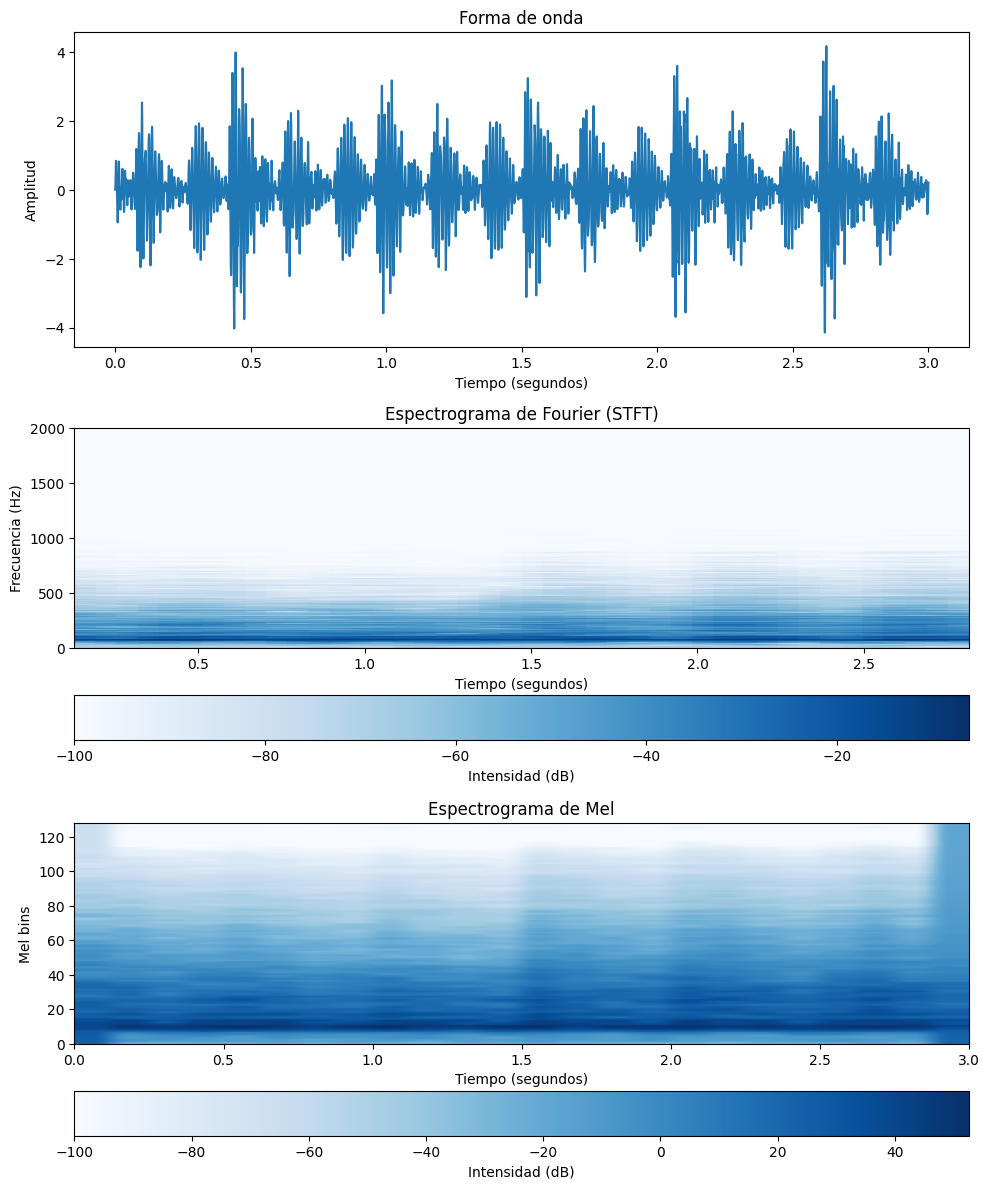

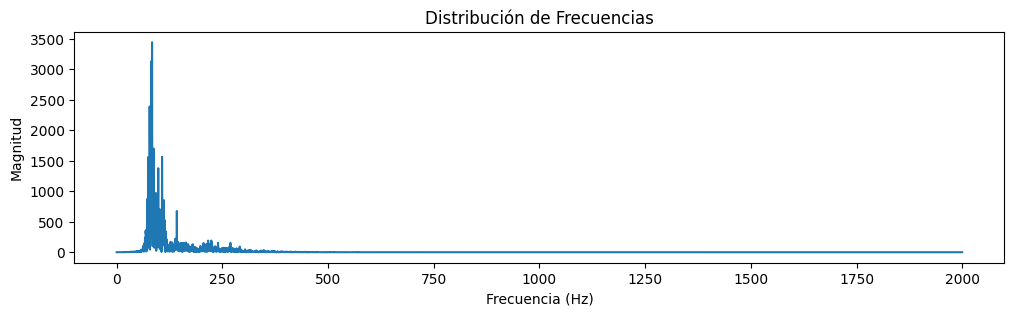

In [5]:
choosen_one = random.randint(0, n_samples - 1)
audio, mel_spectrogram, class_label = cora_dataset[choosen_one]

print(f"#{choosen_one + 1} / {n_samples}")
print(f"Clase: {class_label} - {cora_dataset.idx_to_label[class_label]}")
print(f"Espectrograma: {mel_spectrogram.shape}")
print(f"Forma de onda: {audio.shape}")

cora_plot.plot_waveform_and_spectrograms(
    audio=audio,
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
)
cora_plot.plot_audio_fft(audio, SAMPLE_RATE)
display(Audio(audio, rate=SAMPLE_RATE, autoplay=True))

## Without transformations

Clase: 7 - SAM-Summation Sound
Celular sin transformaciones: 


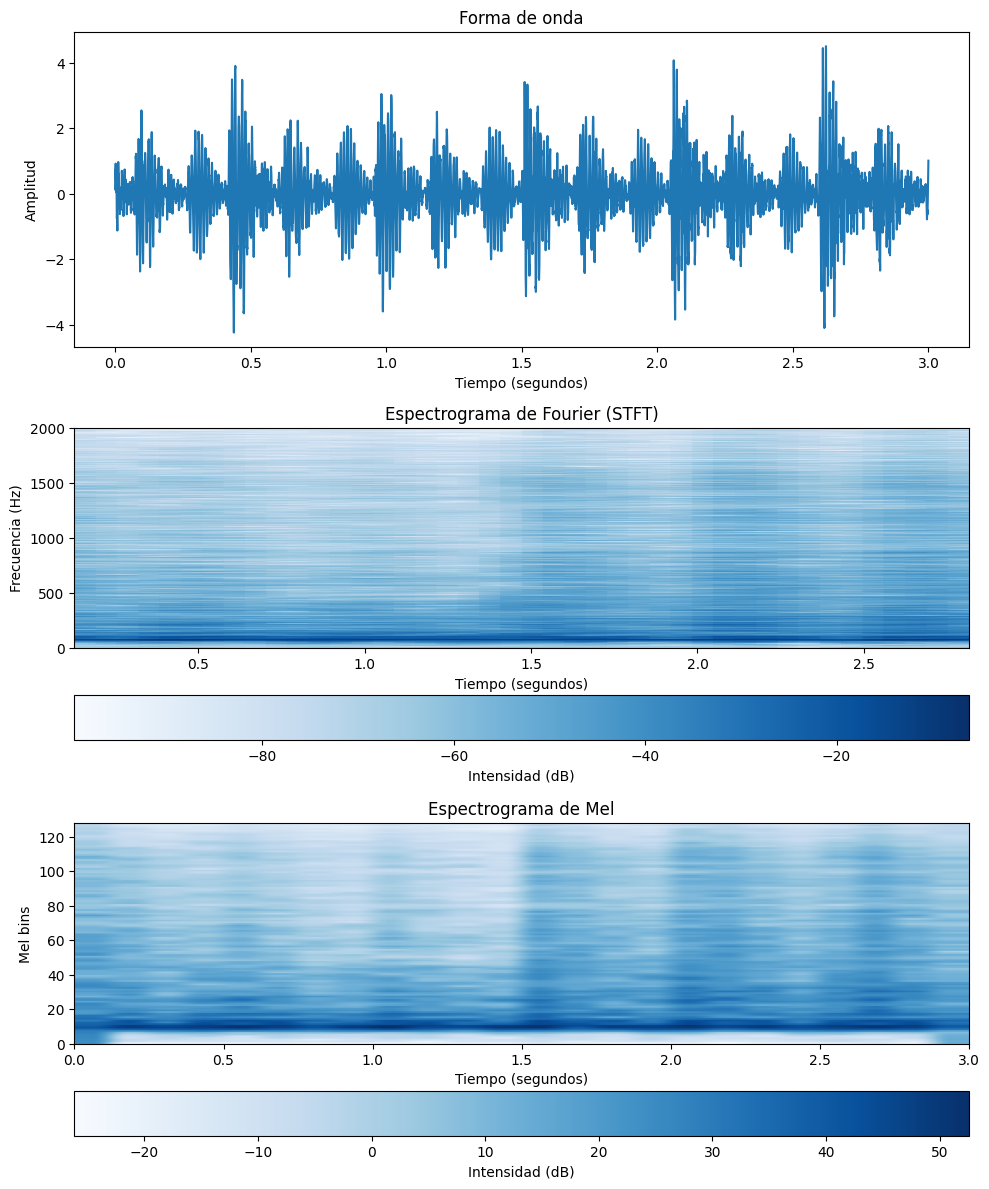

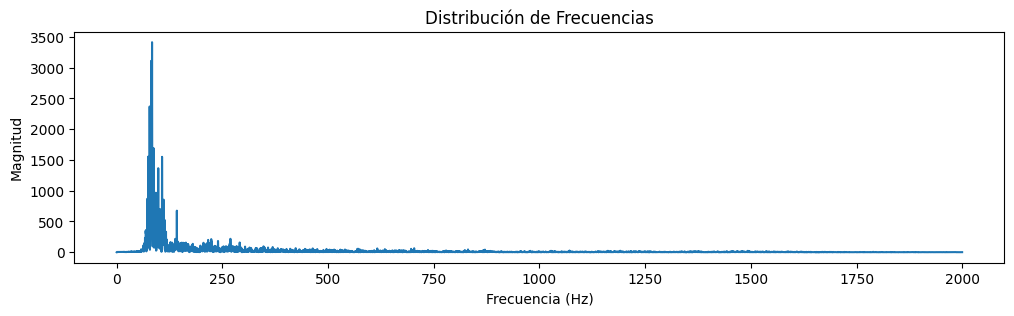

In [6]:
default_transformations = sam_classifier.Compose(
    [
        sam_classifier.ResampleAudio(
            orig_sample_rate=original_sample_rate, new_sample_rate=SAMPLE_RATE
        ),
        sam_classifier.Normalize(),
    ]
)

without_transform = sam_classifier.SAM_Dataset(
    BASE_DIR, CHUNK_SECS, transform=default_transformations
)
audio_original, _, _ = without_transform[choosen_one]

print(f"Clase: {class_label} - {cora_dataset.idx_to_label[class_label]}")
print("Celular sin transformaciones: ")

cora_plot.plot_waveform_and_spectrograms(
    audio=audio_original,
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
)
cora_plot.plot_audio_fft(audio_original, SAMPLE_RATE)
Audio(audio_original, rate=SAMPLE_RATE, autoplay=True)

In [7]:
to_export = {
    "SAM-Celular original": audio_original,
    "SAM-Celular con transformaciones": audio,
}
filedir = get_base_dir().joinpath("data", "mobile", "sam-compare-filters")

for filename, audio in to_export.items():
    save_wave_to_wav(audio.squeeze().numpy(), SAMPLE_RATE, filedir, filename)

El archivo 'SAM-Celular original.wav' se ha guardado exitosamente en:
C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\sam_classifier\data\mobile\sam-compare-filters
El archivo 'SAM-Celular con transformaciones.wav' se ha guardado exitosamente en:
C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\sam_classifier\data\mobile\sam-compare-filters


Compare the original vs the model input

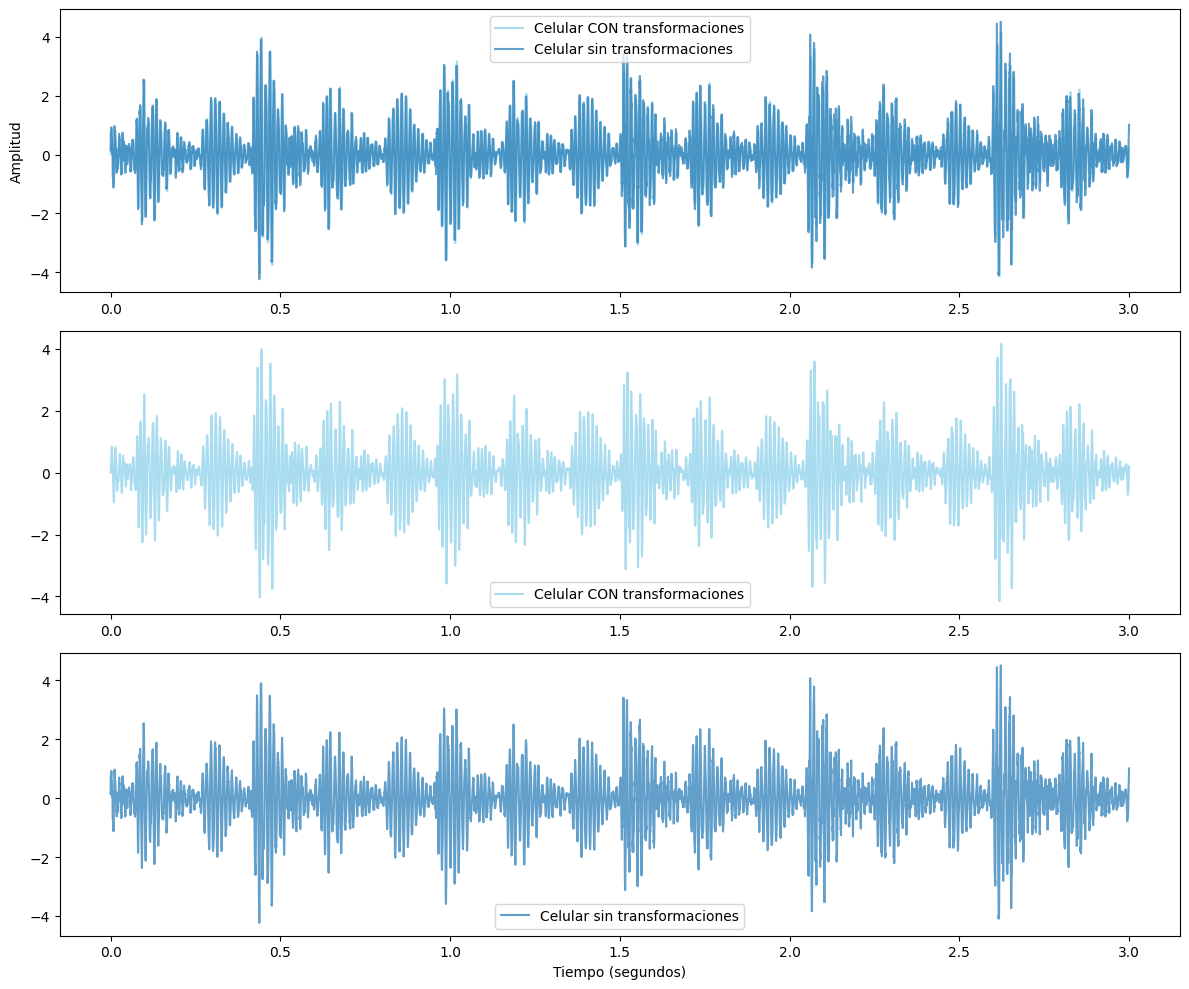

Celular original:


Celular con transformaciones:


In [8]:
cora_plot.compare_audios(
    first_audio=audio,
    first_title="Celular CON transformaciones",
    second_audio=audio_original,
    second_title="Celular sin transformaciones",
    sample_rate=SAMPLE_RATE,
)

print("Celular original:")
display(Audio(audio_original, rate=SAMPLE_RATE, autoplay=True))
print("Celular con transformaciones:")
display(Audio(audio, rate=SAMPLE_RATE, autoplay=True))

# Train, validation and test split

In [9]:
train_size = int(TRAIN_RATIO * len(cora_dataset))
val_size = int(VAL_RATIO * len(cora_dataset))
test_size = len(cora_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    cora_dataset, [train_size, val_size, test_size]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples:\t\t{train_size} = {len(train_dataloader)} batches")
print(f"Validation samples:\t{val_size} = {len(val_dataloader)} batches")
print(f"Test samples:\t\t{test_size} = {len(test_dataloader)} batches")
print(
    f"Total samples:\t\t{train_size + val_size + test_size} = {len(cora_dataset) // BATCH_SIZE} batches"
)

Batch size: 5
Train samples:		288 = 58 batches
Validation samples:	54 = 11 batches
Test samples:		18 = 4 batches
Total samples:		360 = 72 batches


# Callbacks

In [10]:
input_secs = audio.shape[-1] // SAMPLE_RATE
print(f"Tamaño de entrada en segundos: {input_secs}s")

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"checkpoints/input-{input_secs}s",
    filename="model-{val_loss:.4f}-{epoch:02d}",
    save_top_k=1,
    mode="min",
)

early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

Tamaño de entrada en segundos: 3s


# Train!

In [11]:
input_size = cora_dataset[0][0].shape[-1]

print(f"Tamaño de la entrada: {input_size}")
print(f"Tamaño de la salida: {n_classes}")

Tamaño de la entrada: 12000
Tamaño de la salida: 9


In [12]:
# trained_model = sam_classifier.SAM_CNN_Model(n_classes)

# logger = pl.loggers.tensorboard.TensorBoardLogger("logs/", name="coratech_model")

# trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
# trainer.fit(trained_model, train_dataloader, val_dataloader)

# Predict

## Best model

In [13]:
directory = Path("checkpoints").joinpath(f"input-{input_secs}s")
pattern = r"model-val_loss=([\d\.]+)-epoch=\d+\.ckpt"
val_loss_values = {}

for model_path in directory.iterdir():
    if model_path.is_file():
        match = re.match(pattern, model_path.name)
        if match:
            val_loss = float(match.group(1))
            val_loss_values[model_path] = val_loss

if val_loss_values:
    best_model = min(val_loss_values, key=val_loss_values.get)
    print(
        f"The {input_secs}s-input model with the lowest validation loss is:\n{best_model.name}\nwith a loss of {val_loss_values[best_model]}"
    )
else:
    print("No models matching the specified pattern were found.")

The 3s-input model with the lowest validation loss is:
model-val_loss=0.1456-epoch=37.ckpt
with a loss of 0.1456


In [14]:
model_to_pred = sam_classifier.SAM_CNN_Model(n_classes)

model_to_pred.load_state_dict(torch.load(best_model)["state_dict"])
model_to_pred.eval()

SAM_CNN_Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): Batch

# Loss in validation set

In [15]:
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        _, inputs, targets = batch
        predictions = model_to_pred(inputs)
        batch_loss = torch.nn.CrossEntropyLoss()(predictions, targets)
        total_loss += batch_loss.item()
        num_samples += len(inputs)

mse_loss = total_loss / num_samples
print(f"MAE Loss in test set: {mse_loss:.4f}")

MAE Loss in test set: 0.0422


# Result!

#4 / 18


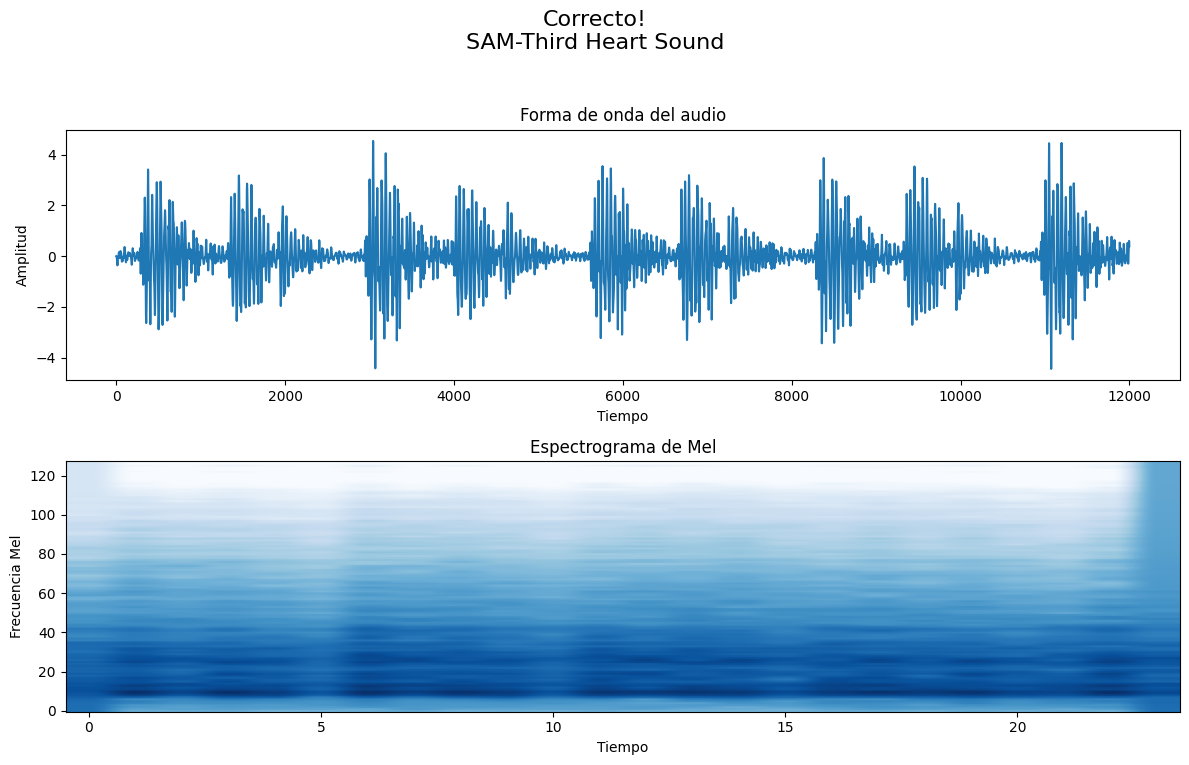

In [18]:
choosen_one_test = random.randint(0, test_size - 1)

print(f"#{choosen_one_test + 1} / {test_size}")

model_result = cora_plot.plot_model_result(
    model_to_pred, test_dataset, choosen_one_test
)

# Confussion Matrix

C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\sam_classifier\helpers\predictions.py:36: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


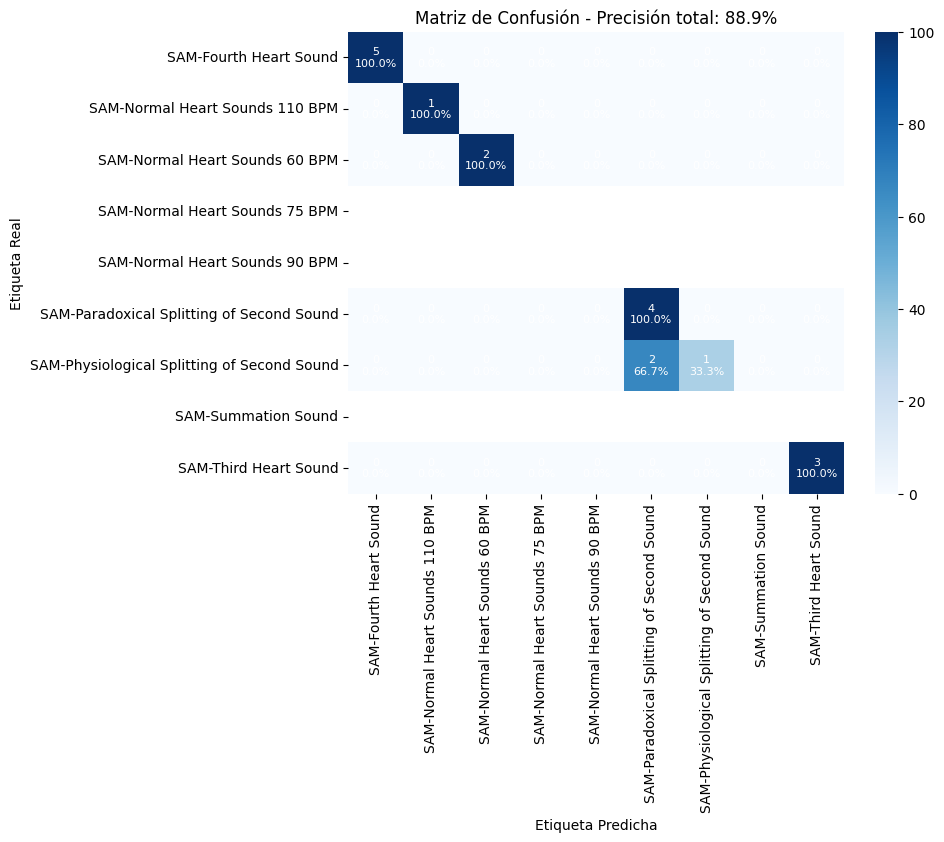

In [17]:
preds, labels, cm = cora_plot.plot_confusion_matrix(model_to_pred, test_dataloader)